In [1]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mvtorch.data import ModelNet40, CustomDataLoader
from tqdm import tqdm
import pandas as pd
import glob
import os
import json
import trimesh

/home/mpelissi/anaconda3/envs/MVTN_env3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Save an example DataFrame to a CSV file
with open("/home/mpelissi/MVTN/my_MVTN/results/train/results_06-06_10h46m35/training_info.json", 'r') as f:
    data_json = json.load(f)
columns = [key for key in data_json.keys() if 'test' not in key and 'train' not in key] + ['pc_rendering']
df = pd.DataFrame(columns=columns)
df.to_csv('/home/mpelissi/MVTN/my_MVTN/results/train/overview.csv', index=False)
df

,gpu_name,folder_name,nb_views,epochs,patience,min_delta,data_dir,category,log_suffix,epoch_earlystop,views_config,opti_mvtn,lr_opti,lr_mvtn_optimizer,weight_decay,batch_size,best_accuracy,best_epoch,pc_rendering


In [3]:
train_folder = '/home/mpelissi/MVTN/my_MVTN/results/train'
json_files = glob.glob(os.path.join(train_folder, '**', 'training_info.json'), recursive=True)
print(len(json_files))

for l, json_file in enumerate(json_files):
    with open(json_file, 'r') as f:
        data_json = json.load(f)
        values = []
        for c in columns:
            if c not in data_json:
                if c == 'pc_rendering':
                    values.append('True')
                else:
                    values.append('not saved')
            elif c == 'lr_opti':
                values.append(str(data_json[c]))
            elif data_json[c] is None:
                values.append('None')
            else:       
                values.append(data_json[c])
        df.loc[l] = values
df.to_csv('/home/mpelissi/MVTN/my_MVTN/results/train/overview.csv', index=False)

8


Scanning directory: /home/mpelissi/Dataset/ModelNet40/ for .obj files...
Found 12311 .obj files and extracted vertex counts for 12311 of them.


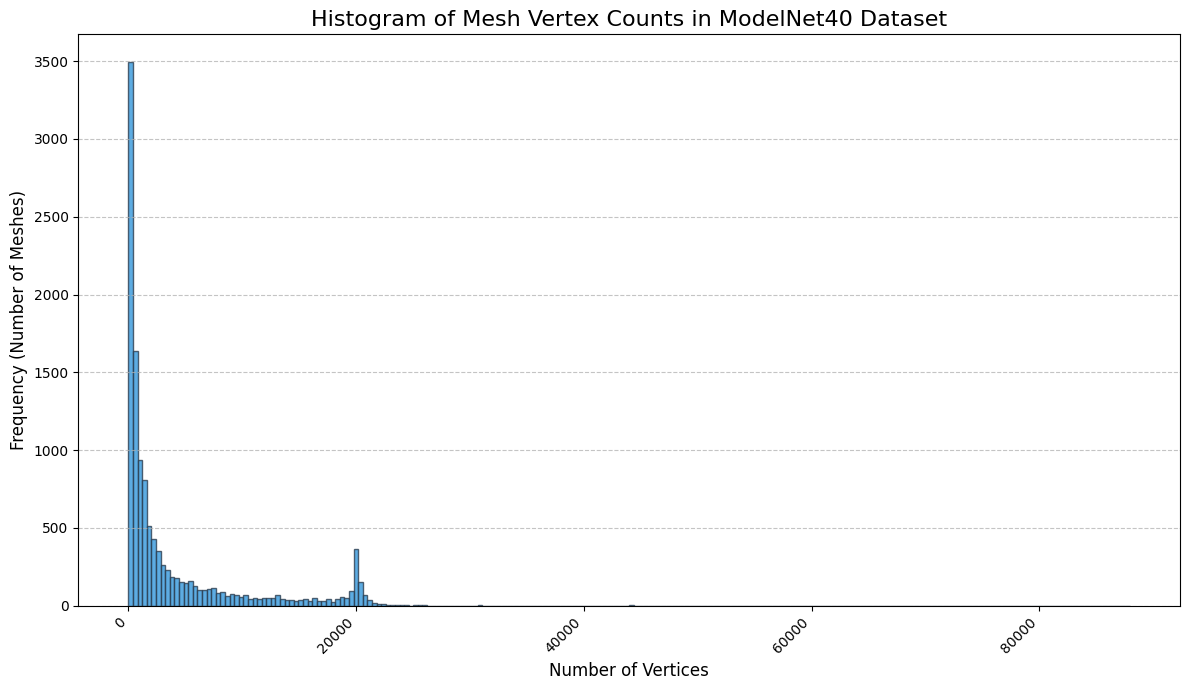

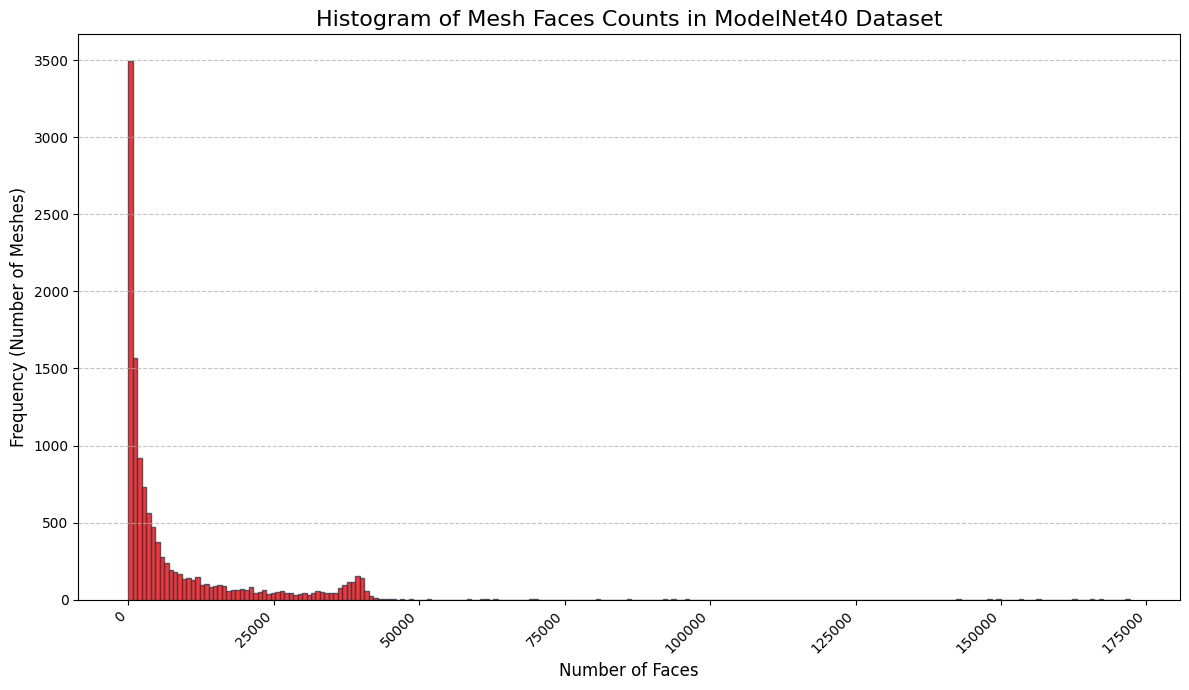

In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tqdm

def count_vertices_in_obj(filepath):
    """
    Counts the number of vertices ('v ' lines) in an OBJ file.
    """
    num_vertices = 0
    num_faces = 0
    try:
        with open(filepath, 'r') as f:
            for line in f:
                if line.startswith('v '):
                    num_vertices += 1
                elif line.startswith('f '):
                    num_faces += 1
    except Exception as e:
        print(f"Warning: Could not read {filepath}. Error: {e}")
        return None
    return num_vertices, num_faces

def generate_vertex_histogram(data_dir, output_filename="mesh_histogram.png"):
    """
    Generates a histogram of vertex counts for all .obj files in a directory.

    Args:
        data_dir (str): The path to the directory containing .obj files.
        output_filename (str): The filename for the saved histogram image.
    """
    if not os.path.isdir(data_dir):
        print(f"Error: Directory not found at {data_dir}")
        return

    vertex_counts = []
    faces_counts = []
    obj_files_found = 0

    print(f"Scanning directory: {data_dir} for .obj files...")
    # Walk through the directory to find all .obj files
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith('.obj') and 'SMPLER' in file:
                obj_files_found += 1
                filepath = os.path.join(root, file)
                # print(f"Found OBJ: {filepath}") # Uncomment for debugging if needed
                num_vertices, num_faces = count_vertices_in_obj(filepath)
                if num_vertices is not None:
                    vertex_counts.append(num_vertices)
                if num_faces is not None:                    
                    faces_counts.append(num_faces)

    if not vertex_counts:
        print(f"No .obj files found or no vertices counted in {data_dir}. Cannot generate histogram.")
        return

    print(f"Found {obj_files_found} .obj files and extracted vertex counts for {len(vertex_counts)} of them.")

    # Convert to numpy array for easier plotting
    vertex_counts = np.array(vertex_counts)
    faces_counts = np.array(faces_counts)

    # --- Plotting the histogram ---
    plt.figure(figsize=(12, 7))
    
    # Determine bins for the histogram
    # Option 1: Fixed number of bins (e.g., 50 bins)
    # plt.hist(vertex_counts, bins=50, color='skyblue', edgecolor='black')
    
    # Option 2: Dynamically calculate bins based on data range
    # You might want to adjust these based on your data distribution
    min_verts = vertex_counts.min()
    max_verts = vertex_counts.max()
    min_faces = faces_counts.min()
    max_faces = faces_counts.max()
    # A common approach is to use a logarithmic scale for bins if counts vary widely
    # Or, if data is concentrated, use a finer linear binning
    
    # Let's try a default of auto-binning which often works well
    plt.hist(vertex_counts, bins='auto', color='#3498DB', edgecolor='#2C3E50', alpha=0.8) # Using a nice blue color
    plt.title('Histogram of Mesh Vertex Counts in ModelNet40 Dataset', fontsize=16)
    plt.xlabel('Number of Vertices', fontsize=12)
    plt.ylabel('Frequency (Number of Meshes)', fontsize=12)
    plt.grid(axis='y', alpha=0.75, linestyle='--')
    plt.yscale('linear') # Can change to 'log' if many small values and few large ones for better visualization
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save the histogram
    plt.figure(figsize=(12, 7))
    plt.savefig(output_filename.replace('.png', "_vertices.png"), dpi=300, bbox_inches='tight')
    plt.hist(faces_counts, bins='auto', color='red', edgecolor='#2C3E50', alpha=0.8) # Using a nice blue color
    plt.title('Histogram of Mesh Faces Counts in ModelNet40 Dataset', fontsize=16)
    plt.xlabel('Number of Faces', fontsize=12)
    plt.ylabel('Frequency (Number of Meshes)', fontsize=12)
    plt.grid(axis='y', alpha=0.75, linestyle='--')
    plt.yscale('linear'); plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save the histogram
    plt.savefig(output_filename.replace('.png', "_faces.png"), dpi=300, bbox_inches='tight')
    return vertex_counts, faces_counts

if __name__ == "__main__":
    modelnet_dir = "/home/mpelissi/Dataset/ModelNet40/"
    vertex_counts, faces_counts = generate_vertex_histogram(modelnet_dir, "modelnet40_vertex_histogram.png")

In [13]:
len(vertex_counts), max(vertex_counts), min(vertex_counts), np.mean(vertex_counts), np.std(vertex_counts)

(12311, 87968, 5, 4169.249939078873, 6269.8700556177155)

In [11]:
len(vertex_counts), max(vertex_counts), min(vertex_counts), np.mean(vertex_counts), np.std(vertex_counts)

(12311, 1143084, 5, 5890.351474291284, 20034.910498643767)

In [ ]:
threeobject = trimesh.load("/home/mpelissi/Dataset/ModelNet40//stairs/train/stairs_0110_SMPLER.obj")
print(threeobject.vertices.shape, threeobject.faces.shape)
threeobject_simplified = threeobject.simplify_quadric_decimation(percent=0.5)
print(threeobject_simplified.vertices.shape, threeobject_simplified.faces.shape)